In [1]:
import pandas as pd
import preprocessing
from pathlib import Path

DATA_DIR = Path("..","data")
COMMON_DATA_DIR = Path("..","..","common","src","data")
RAWDF_DIR = COMMON_DATA_DIR/"rawdf"

リメイク版動画＃７　LightGBMを使って単勝馬券の予測をしてみる

In [2]:
INPUT_DIR = Path("..","data","02_features")
features = pd.read_csv(INPUT_DIR / "features.csv", sep = "\t")

In [ ]:
features.columns

Index(['race_id', 'horse_id', 'date', 'jockey_id', 'trainer_id', 'rank', 'sex',
       'age', 'weight', 'weight_diff', 'tansho_odds', 'popularity', 'impost',
       'wakuban', 'umaban', 'race_type', 'around', 'course_len', 'weather',
       'ground_state', 'race_class', 'place', 'rank_1race', 'prize_1race',
       'rank_3races', 'prize_3races', 'rank_5races', 'prize_5races',
       'rank_10races', 'prize_10races', 'rank_1000races', 'prize_1000races'],
      dtype='object')

In [86]:
feature_cols = [
    'horse_id', 
    'jockey_id', 
    'trainer_id', 
    'sex',
    'age', 
    'weight', 
    'weight_diff', 
    # 'tansho_odds', 
    # 'popularity', 
    'impost',
    'wakuban', 
    'umaban', 
    'race_type', 
    'around', 
    'course_len', 
    'weather',
    'ground_state', 
    'race_class',
    'place',
    'rank_1race',
    'prize_1race',
    'rank_3races',
    'prize_3races',
    'rank_5races',
    'prize_5races',
    'rank_10races',
    'prize_10races',
    'rank_1000races',
    'prize_1000races'
]

In [87]:
#説明変数
X = features[feature_cols]

In [ ]:
#目的変数
y = (features["rank"] == 1).astype(int)

In [189]:
features["target"] = (features["rank"] == 1).astype(int)
# features["target"] = (features["rank"] <= 3).astype(int)
# features["target"] = features["rank"]

## ホールドアウト法
データを学習データと検証データにわける

In [190]:
train_df = features.query("date < '2024-09-01' and date > '2024-01-01'")
test_df = features.query("date >= '2024-09-01'")

In [39]:
len(train_df), len(test_df)

(34376, 6714)

In [192]:
import lightgbm as lgb

#データセットの作成
lgb_train = lgb.Dataset(
    train_df[feature_cols], train_df["target"]
)

lgb_test = lgb.Dataset(
    test_df[feature_cols], test_df["target"]
)

#パラメータの設定
params = {
    "objective": "binary", # 二値分類
    "metric": "binary_logloss", # 予測誤差
    "random_state":100 # 実行ごとに同じ結果を得るための設定
}

#学習の実行
model = lgb.train(
    params = params,
    train_set = lgb_train,
    valid_sets = [lgb_train, lgb_test],
    callbacks = [lgb.log_evaluation()]
)


[LightGBM] [Info] Number of positive: 2349, number of negative: 29583
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 31932, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073563 -> initscore=-2.533210
[LightGBM] [Info] Start training from score -2.533210
[1]	training's binary_logloss: 0.2558	valid_1's binary_logloss: 0.266739
[2]	training's binary_logloss: 0.250515	valid_1's binary_logloss: 0.263304
[3]	training's binary_logloss: 0.246344	valid_1's binary_logloss: 0.260403
[4]	training's binary_logloss: 0.242931	valid_1's binary_logloss: 0.258565
[5]	training's binary_logloss: 0.239815	valid_1's binary_logloss: 0.256566
[6]	training's binary_logloss: 0.237399	valid_1's binary_logloss: 0.255259
[7]	training's binary_logloss: 0.235058	valid_1's binary_lo

In [120]:
import graphviz
import matplotlib.pyplot as plt

# オフライン評価
的中率・回収率を見てみる

In [193]:
#テストデータに対して予測をしてみる
model.predict(test_df[feature_cols])

array([0.11821092, 0.22213302, 0.18853782, ..., 0.1822257 , 0.09393408,
       0.10069295])

In [ ]:
goal.

array([1., 1., 1., ..., 1., 1., 1.])

In [194]:
evaluation_df =test_df[
    [
        "race_id",
        "horse_id",
        "target",
        "rank",
        "tansho_odds",
        "popularity"
    ]
].copy()

In [159]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity
49223,202401020801,2022104326,0,7,93.6,8
49224,202401020801,2022102780,0,5,6.1,2
49225,202401020801,2022104672,0,4,9.7,4
49226,202401020801,2022104382,1,2,9.6,3
49227,202401020801,2022102371,0,8,164.7,10
...,...,...,...,...,...,...
81996,202408060612,2020103969,0,7,25.2,9
81997,202408060612,2021105127,0,4,19.4,7
81998,202408060612,2019106925,1,2,5.4,2
81999,202408060612,2021102246,0,9,14.3,5


In [195]:
evaluation_df["pred"] = model.predict(test_df[feature_cols])

In [196]:
evaluation_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
49223,202401020801,2022104326,0,7,93.6,8,0.118211
49224,202401020801,2022102780,0,5,6.1,2,0.222133
49225,202401020801,2022104672,0,4,9.7,4,0.188538
49226,202401020801,2022104382,0,2,9.6,3,0.269319
49227,202401020801,2022102371,0,8,164.7,10,0.044694
...,...,...,...,...,...,...,...
81996,202408060612,2020103969,0,7,25.2,9,0.070035
81997,202408060612,2021105127,0,4,19.4,7,0.068399
81998,202408060612,2019106925,0,2,5.4,2,0.182226
81999,202408060612,2021102246,0,9,14.3,5,0.093934


predの値が一番高いものに、単勝馬券で賭ける場合を考える

In [197]:
bet_df = (
    evaluation_df
    .sort_values("pred",ascending=False)
    .groupby("race_id")
    .head(1)
    # .tail(1)
)


In [198]:
#的中率
bet_df["target"].mean()

np.float64(0.24964539007092199)

In [199]:
#返ってくる金額
return_ = ((bet_df["target"] == 1) * bet_df["tansho_odds"]).sum()
return_

np.float64(548.6)

In [179]:
#賭けた金額
cost = len(bet_df)
cost

705

In [180]:
#回収率
return_ / cost

np.float64(1.9848226950354613)

In [186]:
#　一番人気に賭け続けた場合に勝っているか
bet_ninki_df = (
    evaluation_df
    .sort_values("popularity")
    .groupby("race_id")
    # .head(1)
    .head(1)
)

In [187]:
#的中率
bet_ninki_df["target"].mean()

np.float64(0.6836879432624113)

In [188]:
#回収率
#返ってくる金額
return_ = ((bet_ninki_df["target"] == 1) * bet_ninki_df["tansho_odds"]).sum()
return_
#賭けた金額
cost = len(bet_ninki_df)
cost

return_ / cost

np.float64(1.6975886524822699)

In [170]:
#一番人気と違う馬の回収率
bet_not_ninki_df = (
    evaluation_df
    .sort_values("pred",ascending= False)
    .groupby("race_id")
    .head(1)
    .query("popularity != 1")
)
bet_not_ninki_df

,race_id,horse_id,target,rank,tansho_odds,popularity,pred
64136,202405040503,2022105109,0,4,2.4,2,0.810088
69638,202406040101,2019103005,1,3,2.3,2,0.796445
65184,202405050402,2022104761,1,3,2.5,2,0.786910
73398,202407030203,2022106768,1,1,5.0,2,0.755392
80966,202408050703,2022105108,1,2,3.2,2,0.745334
...,...,...,...,...,...,...,...
74366,202407030905,2022100651,0,14,6.6,4,0.238308
74395,202407030906,2020100716,0,6,6.6,3,0.237533
53780,202403030306,2021100643,0,10,28.1,10,0.233307
64302,202405040604,2022106908,0,15,102.9,13,0.229226


In [171]:
#的中率
bet_not_ninki_df["target"].mean()

np.float64(0.3944723618090452)

In [172]:
#回収率
#返ってくる金額
return_ = ((bet_not_ninki_df["target"] == 1) * bet_not_ninki_df["tansho_odds"]).sum()
return_
#賭けた金額
cost = len(bet_not_ninki_df)
cost

return_ / cost

np.float64(2.333417085427136)

In [57]:
import matplotlib

# lightgbmは何をやっているのか

<Axes: >

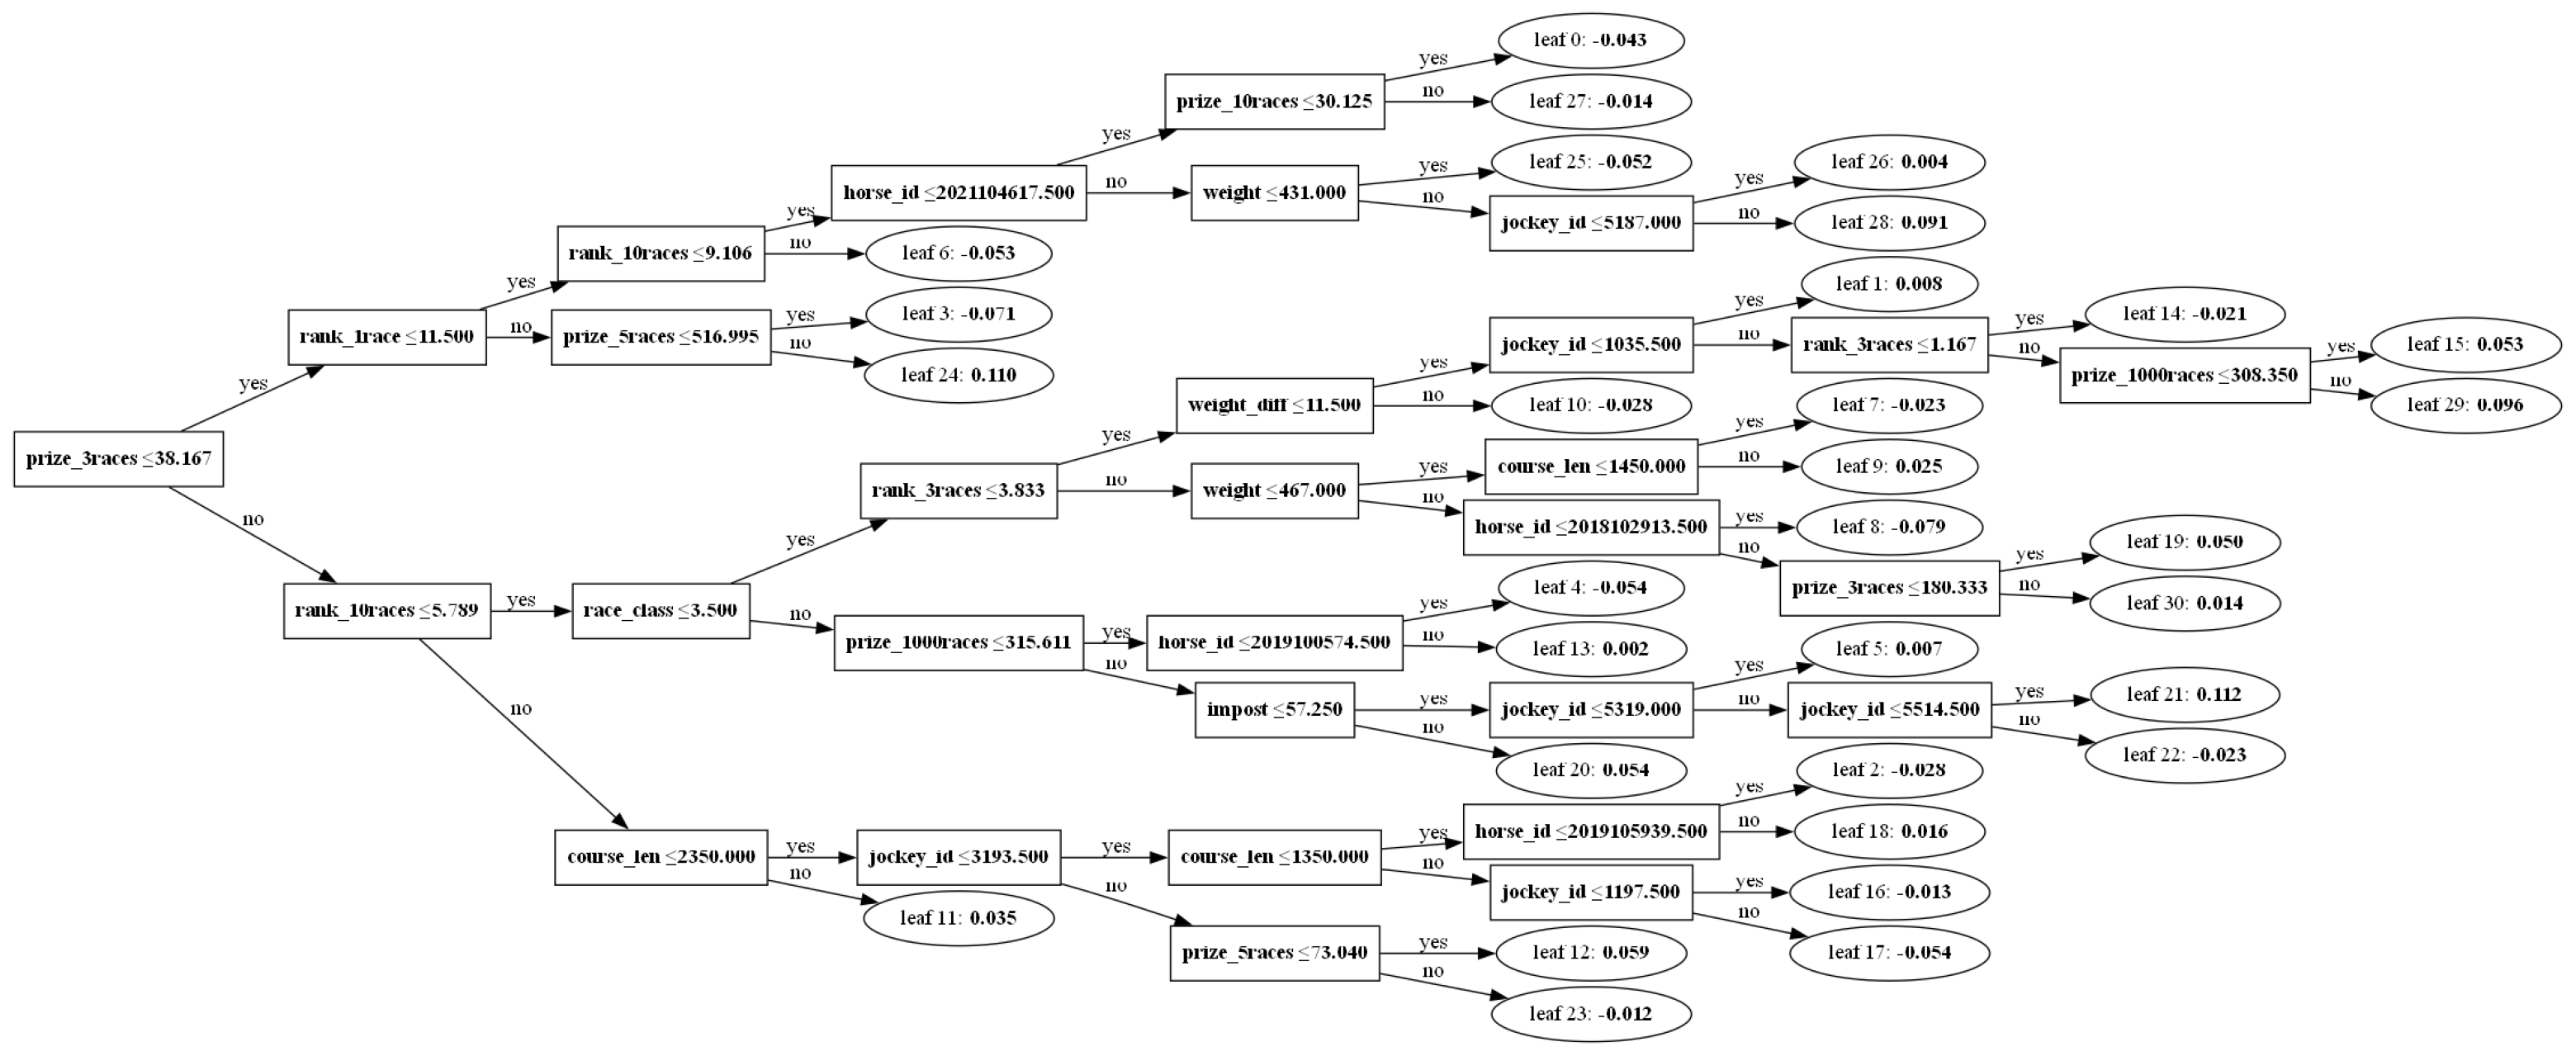

In [173]:
lgb.plot_tree(model,tree_index= 10, figsize= (40,20))
# lgb.plot_tree(model)

## 特徴量重要度
モデルにインプットしたデータの中で、どの特徴量（列）が一番学習に使われているか

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

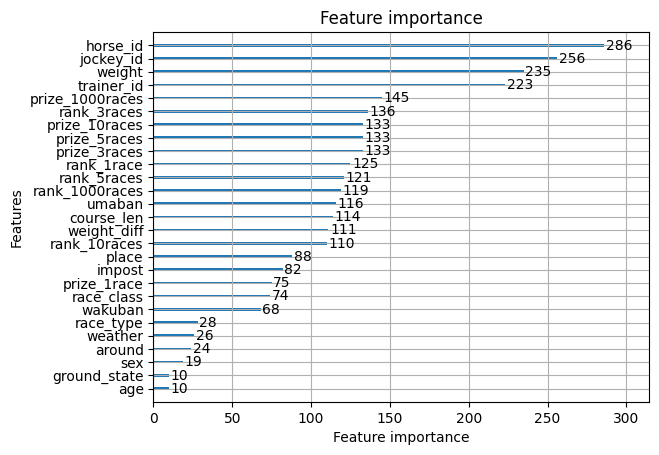

In [174]:
lgb.plot_importance(model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

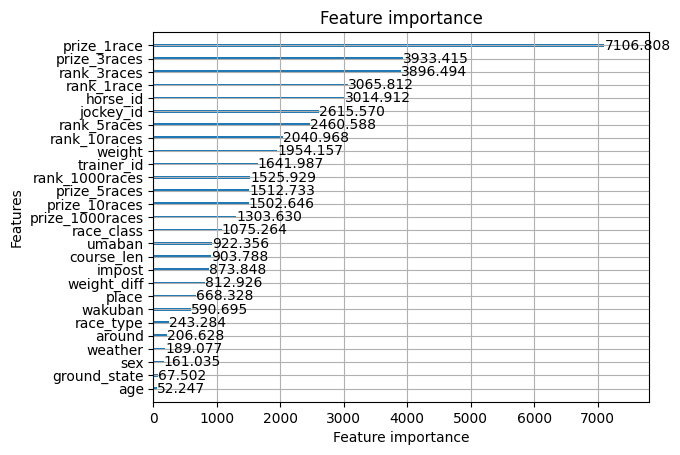

In [175]:
lgb.plot_importance(model,importance_type="gain")

# 予測時の処理
## レース前日準備

In [ ]:
horse_results_preprocessed = preprocessing.process_horse_results(
    save_filename="horse_results_prediction.csv"
)

In [ ]:
horse_results_preprocessed[horse_results_preprocessed["rank_diff"].isnull()]

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses
3979,2018105192,2023-04-15,7,0.0,NaN,NaN,1,1400,2,NaN,11
4159,2020110136,2023-02-25,12,0.0,NaN,NaN,0,1600,0,NaN,13
